<a href="https://colab.research.google.com/github/Oleksii-Adamov/text-detection-recognition-project/blob/main/Oleksii_notebooks/keras_ocr_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 24 kB/s 
     |████████████████████████████████| 463 kB 20.8 MB/s 
     |████████████████████████████████| 1.3 MB 57.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220

In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.3 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149860 sha256=a60e1886e9bdb7560a38facfcf782b6a7529159a31267f506290c01ada47e2b0
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git@v0.8.7
!pip install -U opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git (to revision v0.8.7) to /tmp/pip-req-build-996vj_os
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-req-build-996vj_os
  Running command git checkout -q c47646c43dc3cb71812db08bdb3843cfa783d8cc
     |████████████████████████████████| 9.5 MB 18.2 MB/s 
     |████████████████████████████████| 957 kB 53.9 MB/s 
     |████████████████████████████████| 604 kB 56.1 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.7-py3-none-any.whl size=149802 sha256=6c42986dd00837944128a569cfa30ff8e22a0a7be63c729aaa99aa10833fa7d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-4v23xz6k/wheels/85/f5/d0/c76aa6ee0e117ae9863d5797d31a5ed45a1d15a923a55391ff
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=02b9

# Image generation fix for keras-ocr

In [ ]:
import os
import io
import typing
import hashlib
import urllib.request
import urllib.parse

import cv2
import imgaug
import numpy as np
import validators
import typing_extensions as tx
import matplotlib.pyplot as plt
from shapely import geometry
from scipy import spatial


def read(filepath_or_buffer: typing.Union[str, io.BytesIO, np.ndarray]):
    """Read a file into an image object
    Args:
        filepath_or_buffer: The path to the file, a URL, or any object
            with a `read` method (such as `io.BytesIO`)
    """
    if isinstance(filepath_or_buffer, np.ndarray):
        return filepath_or_buffer
    if hasattr(filepath_or_buffer, "read"):
        image = np.asarray(bytearray(filepath_or_buffer.read()), dtype=np.uint8)  # type: ignore
        image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
    elif isinstance(filepath_or_buffer, str):
        if validators.url(filepath_or_buffer):
            return read(urllib.request.urlopen(filepath_or_buffer))
        assert os.path.isfile(filepath_or_buffer), (
            "Could not find image at path: " + filepath_or_buffer
        )
        image = cv2.imread(filepath_or_buffer)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def get_rotated_width_height(box):
    """
    Returns the width and height of a rotated rectangle
    Args:
        box: A list of four points starting in the top left
        corner and moving clockwise.
    """
    w = (
        spatial.distance.cdist(box[0][np.newaxis], box[1][np.newaxis], "euclidean")
        + spatial.distance.cdist(box[2][np.newaxis], box[3][np.newaxis], "euclidean")
    ) / 2
    h = (
        spatial.distance.cdist(box[0][np.newaxis], box[3][np.newaxis], "euclidean")
        + spatial.distance.cdist(box[1][np.newaxis], box[2][np.newaxis], "euclidean")
    ) / 2
    return int(w[0][0]), int(h[0][0])


# pylint:disable=too-many-locals
def warpBox(
    image,
    box,
    target_height=None,
    target_width=None,
    margin=0,
    cval=None,
    return_transform=False,
    skip_rotate=False,
):
    """Warp a boxed region in an image given by a set of four points into
    a rectangle with a specified width and height. Useful for taking crops
    of distorted or rotated text.
    Args:
        image: The image from which to take the box
        box: A list of four points starting in the top left
            corner and moving clockwise.
        target_height: The height of the output rectangle
        target_width: The width of the output rectangle
        return_transform: Whether to return the transformation
            matrix with the image.
    """
    if cval is None:
        cval = (0, 0, 0) if len(image.shape) == 3 else 0
    if not skip_rotate:
        box, _ = get_rotated_box(box)
    w, h = get_rotated_width_height(box)
    assert (target_width is None and target_height is None) or (
        target_width is not None and target_height is not None
    ), "Either both or neither of target width and height must be provided."
    if target_width is None and target_height is None:
        target_width = w
        target_height = h
    scale = min(target_width / w, target_height / h)
    M = cv2.getPerspectiveTransform(
        src=box,
        dst=np.array(
            [
                [margin, margin],
                [scale * w - margin, margin],
                [scale * w - margin, scale * h - margin],
                [margin, scale * h - margin],
            ]
        ).astype("float32"),
    )
    crop = cv2.warpPerspective(image, M, dsize=(int(scale * w), int(scale * h)))
    target_shape = (
        (target_height, target_width, 3)
        if len(image.shape) == 3
        else (target_height, target_width)
    )
    full = (np.zeros(target_shape) + cval).astype("uint8")
    full[: crop.shape[0], : crop.shape[1]] = crop
    if return_transform:
        return full, M
    return full


def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]


def combine_line(line):
    """Combine a set of boxes in a line into a single bounding
    box.
    Args:
        line: A list of (box, character) entries
    Returns:
        A (box, text) tuple
    """
    text = "".join(
        [character if character is not None else "" for _, character in line]
    )
    box = np.concatenate(
        [coords[:2] for coords, _ in line]
        + [np.array([coords[3], coords[2]]) for coords, _ in reversed(line)]
    ).astype("float32")
    first_point = box[0]
    rectangle = cv2.minAreaRect(box)
    box = cv2.boxPoints(rectangle)

    # Put the points in clockwise order
    box = np.array(np.roll(box, -np.linalg.norm(box - first_point, axis=1).argmin(), 0))
    return box, text


def drawAnnotations(image, predictions, ax=None):
    """Draw text annotations onto image.
    Args:
        image: The image on which to draw
        predictions: The predictions as provided by `pipeline.recognize`.
        ax: A matplotlib axis on which to draw.
    """
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(drawBoxes(image=image, boxes=predictions, boxes_format="predictions"))
    predictions = sorted(predictions, key=lambda p: p[1][:, 1].min())
    left = []
    right = []
    for word, box in predictions:
        if box[:, 0].min() < image.shape[1] / 2:
            left.append((word, box))
        else:
            right.append((word, box))
    ax.set_yticks([])
    ax.set_xticks([])
    for side, group in zip(["left", "right"], [left, right]):
        for index, (text, box) in enumerate(group):
            y = 1 - (index / len(group))
            xy = box[0] / np.array([image.shape[1], image.shape[0]])
            xy[1] = 1 - xy[1]
            ax.annotate(
                text=text,
                xy=xy,
                xytext=(-0.05 if side == "left" else 1.05, y),
                xycoords="axes fraction",
                arrowprops={"arrowstyle": "->", "color": "r"},
                color="r",
                fontsize=14,
                horizontalalignment="right" if side == "left" else "left"
            )
    return ax


def drawBoxes(image, boxes, color=(255, 0, 0), thickness=5, boxes_format="boxes"):
    """Draw boxes onto an image.
    Args:
        image: The image on which to draw the boxes.
        boxes: The boxes to draw.
        color: The color for each box.
        thickness: The thickness for each box.
        boxes_format: The format used for providing the boxes. Options are
            "boxes" which indicates an array with shape(N, 4, 2) where N is the
            number of boxes and each box is a list of four points) as provided
            by `keras_ocr.detection.Detector.detect`, "lines" (a list of
            lines where each line itself is a list of (box, character) tuples) as
            provided by `keras_ocr.data_generation.get_image_generator`,
            or "predictions" where boxes is by itself a list of (word, box) tuples
            as provided by `keras_ocr.pipeline.Pipeline.recognize` or
            `keras_ocr.recognition.Recognizer.recognize_from_boxes`.
    """
    if len(boxes) == 0:
        return image
    canvas = image.copy()
    if boxes_format == "lines":
        revised_boxes = []
        for line in boxes:
            for box, _ in line:
                revised_boxes.append(box)
        boxes = revised_boxes
    if boxes_format == "predictions":
        revised_boxes = []
        for _, box in boxes:
            revised_boxes.append(box)
        boxes = revised_boxes
    for box in boxes:
        cv2.polylines(
            img=canvas,
            pts=box[np.newaxis].astype("int32"),
            color=color,
            thickness=thickness,
            isClosed=True,
        )
    return canvas


def adjust_boxes(
    boxes,
    scale=1,
    boxes_format: tx.Literal["boxes", "predictions", "lines"] = "boxes",
) -> typing.Union[
    np.ndarray,
    typing.List[typing.List[typing.Tuple[np.ndarray, str]]],
    typing.List[typing.Tuple[str, np.ndarray]],
]:
    """Adjust boxes using a given scale and offset.
    Args:
        boxes: The boxes to adjust
        boxes_format: The format for the boxes. See the `drawBoxes` function
            for an explanation on the options.
        scale: The scale to apply
    """
    if scale == 1:
        return boxes
    if boxes_format == "boxes":
        return np.array(boxes) * scale
    if boxes_format == "lines":
        return [
            [(np.array(box) * scale, character) for box, character in line]
            for line in boxes
        ]
    if boxes_format == "predictions":
        return [(word, np.array(box) * scale) for word, box in boxes]
    raise NotImplementedError(f"Unsupported boxes format: {boxes_format}")


def augment(
    boxes,
    augmenter: imgaug.augmenters.meta.Augmenter,
    image=None,
    boxes_format="boxes",
    image_shape=None,
    area_threshold=0.5,
    min_area=None,
):
    """Augment an image and associated boxes together.
    Args:
        image: The image which we wish to apply the augmentation.
        boxes: The boxes that will be augmented together with the image
        boxes_format: The format for the boxes. See the `drawBoxes` function
            for an explanation on the options.
        image_shape: The shape of the input image if no image will be provided.
        area_threshold: Fraction of bounding box that we require to be
            in augmented image to include it.
        min_area: The minimum area for a character to be included.
    """
    if image is None and image_shape is None:
        raise ValueError('One of "image" or "image_shape" must be provided.')
    augmenter = augmenter.to_deterministic()

    if image is not None:
        image_augmented = augmenter(image=image)
        image_shape = image.shape[:2]
        image_augmented_shape = image_augmented.shape[:2]
    else:
        image_augmented = None
        width_augmented, height_augmented = augmenter.augment_keypoints(
            imgaug.KeypointsOnImage.from_xy_array(
                xy=[[image_shape[1], image_shape[0]]], shape=image_shape
            )
        ).to_xy_array()[0]
        image_augmented_shape = (height_augmented, width_augmented)

    def box_inside_image(box):
        area_before = cv2.contourArea(np.array(box, dtype="int32")[:, np.newaxis, :])
        if area_before == 0:
            return False, box
        clipped = box.copy()
        clipped[:, 0] = clipped[:, 0].clip(0, image_augmented_shape[1])
        clipped[:, 1] = clipped[:, 1].clip(0, image_augmented_shape[0])
        area_after = cv2.contourArea(np.array(clipped, dtype="int32")[:, np.newaxis, :])
        return ((area_after / area_before) >= area_threshold) and (
            min_area is None or area_after > min_area
        ), clipped

    def augment_box(box):
        return augmenter.augment_keypoints(
            imgaug.KeypointsOnImage.from_xy_array(box, shape=image_shape)
        ).to_xy_array()

    if boxes_format == "boxes":
        boxes_augmented = [
            box
            for inside, box in [
                box_inside_image(box) for box in map(augment_box, boxes)
            ]
            if inside
        ]
    elif boxes_format == "lines":
        boxes_augmented = [
            [(augment_box(box), character) for box, character in line] for line in boxes
        ]
        boxes_augmented = [
            [
                (box, character)
                for (inside, box), character in [
                    (box_inside_image(box), character) for box, character in line
                ]
                if inside
            ]
            for line in boxes_augmented
        ]
        # Sometimes all the characters in a line are removed.
        boxes_augmented = [line for line in boxes_augmented if line]
    elif boxes_format == "predictions":
        boxes_augmented = [(word, augment_box(box)) for word, box in boxes]
        boxes_augmented = [
            (word, box)
            for word, (inside, box) in [
                (word, box_inside_image(box)) for word, box in boxes_augmented
            ]
            if inside
        ]
    else:
        raise NotImplementedError(f"Unsupported boxes format: {boxes_format}")
    return image_augmented, boxes_augmented


def pad(image, width: int, height: int, cval: int = 255):
    """Pad an image to a desired size. Raises an exception if image
    is larger than desired size.
    Args:
        image: The input image
        width: The output width
        height: The output height
        cval: The value to use for filling the image.
    """
    output_shape: typing.Union[typing.Tuple[int, int, int], typing.Tuple[int, int]]
    if len(image.shape) == 3:
        output_shape = (height, width, image.shape[-1])
    else:
        output_shape = (height, width)
    assert height >= output_shape[0], "Input height must be less than output height."
    assert width >= output_shape[1], "Input width must be less than output width."
    padded = np.zeros(output_shape, dtype=image.dtype) + cval
    padded[: image.shape[0], : image.shape[1]] = image
    return padded


def resize_image(image, max_scale, max_size):
    """Obtain the optimal resized image subject to a maximum scale
    and maximum size.
    Args:
        image: The input image
        max_scale: The maximum scale to apply
        max_size: The maximum size to return
    """
    if max(image.shape) * max_scale > max_size:
        # We are constrained by the maximum size
        scale = max_size / max(image.shape)
    else:
        # We are contrained by scale
        scale = max_scale
    return (
        cv2.resize(
            image, dsize=(int(image.shape[1] * scale), int(image.shape[0] * scale))
        ),
        scale,
    )


# pylint: disable=too-many-arguments
def fit(
    image,
    width: int,
    height: int,
    cval: int = 255,
    mode="letterbox",
    return_scale=False,
):
    """Obtain a new image, fit to the specified size.
    Args:
        image: The input image
        width: The new width
        height: The new height
        cval: The constant value to use to fill the remaining areas of
            the image
        return_scale: Whether to return the scale used for the image
    Returns:
        The new image
    """
    fitted = None
    x_scale = width / image.shape[1]
    y_scale = height / image.shape[0]
    if x_scale == 1 and y_scale == 1:
        fitted = image
        scale = 1
    elif (x_scale <= y_scale and mode == "letterbox") or (
        x_scale >= y_scale and mode == "crop"
    ):
        scale = width / image.shape[1]
        resize_width = width
        resize_height = (width / image.shape[1]) * image.shape[0]
    else:
        scale = height / image.shape[0]
        resize_height = height
        resize_width = scale * image.shape[1]
    if fitted is None:
        resize_width, resize_height = map(int, [resize_width, resize_height])
        if mode == "letterbox":
            fitted = np.zeros((height, width, 3), dtype="uint8") + cval
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted[: image.shape[0], : image.shape[1]] = image[:height, :width]
        elif mode == "crop":
            image = cv2.resize(image, dsize=(resize_width, resize_height))
            fitted = image[:height, :width]
        else:
            raise NotImplementedError(f"Unsupported mode: {mode}")
    if not return_scale:
        return fitted
    return fitted, scale


def read_and_fit(
    filepath_or_array: typing.Union[str, np.ndarray],
    width: int,
    height: int,
    cval: int = 255,
    mode="letterbox",
):
    """Read an image from disk and fit to the specified size.
    Args:
        filepath: The path to the image or numpy array of shape HxWx3
        width: The new width
        height: The new height
        cval: The constant value to use to fill the remaining areas of
            the image
        mode: The mode to pass to "fit" (crop or letterbox)
    Returns:
        The new image
    """
    image = (
        read(filepath_or_array)
        if isinstance(filepath_or_array, str)
        else filepath_or_array
    )
    image = fit(image=image, width=width, height=height, cval=cval, mode=mode)
    return image


def sha256sum(filename):
    """Compute the sha256 hash for a file."""
    h = hashlib.sha256()
    b = bytearray(128 * 1024)
    mv = memoryview(b)
    with open(filename, "rb", buffering=0) as f:
        for n in iter(lambda: f.readinto(mv), 0):  # type: ignore
            h.update(mv[:n])
    return h.hexdigest()


def get_default_cache_dir():
    return os.environ.get(
        "KERAS_OCR_CACHE_DIR", os.path.expanduser(os.path.join("~", ".keras-ocr"))
    )


def download_and_verify(url, sha256=None, cache_dir=None, verbose=True, filename=None):
    """Download a file to a cache directory and verify it with a sha256
    hash.
    Args:
        url: The file to download
        sha256: The sha256 hash to check. If the file already exists and the hash
            matches, we don't download it again.
        cache_dir: The directory in which to cache the file. The default is
            `~/.keras-ocr`.
        verbose: Whether to log progress
        filename: The filename to use for the file. By default, the filename is
            derived from the URL.
    """
    if cache_dir is None:
        cache_dir = get_default_cache_dir()
    if filename is None:
        filename = os.path.basename(urllib.parse.urlparse(url).path)
    filepath = os.path.join(cache_dir, filename)
    os.makedirs(os.path.split(filepath)[0], exist_ok=True)
    if verbose:
        print("Looking for " + filepath)
    if not os.path.isfile(filepath) or (sha256 and sha256sum(filepath) != sha256):
        if verbose:
            print("Downloading " + filepath)
        urllib.request.urlretrieve(url, filepath)
    assert sha256 is None or sha256 == sha256sum(
        filepath
    ), "Error occurred verifying sha256."
    return filepath


def get_rotated_box(
    points,
) -> typing.Tuple[np.ndarray, float,]:
    """Obtain the parameters of a rotated box.
    Returns:
        The vertices of the rotated box in top-left,
        top-right, bottom-right, bottom-left order along
        with the angle of rotation about the bottom left corner.
    """
    try:
        mp = geometry.MultiPoint(points=points)
        pts = np.array(list(zip(*mp.minimum_rotated_rectangle.exterior.xy)))[
            :-1
        ]  # noqa: E501
    except AttributeError:
        # There weren't enough points for the minimum rotated rectangle function
        pts = points
    # The code below is taken from
    # https://github.com/jrosebr1/imutils/blob/master/imutils/perspective.py

    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = spatial.distance.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    pts = np.array([tl, tr, br, bl], dtype="float32")

    rotation = np.arctan((tl[0] - bl[0]) / (tl[1] - bl[1]))
    return pts, rotation


def fix_line(line):
    """Given a list of (box, character) tuples, return a revised
    line with a consistent ordering of left-to-right or top-to-bottom,
    with each box provided with (top-left, top-right, bottom-right, bottom-left)
    ordering.
    Returns:
        A tuple that is the fixed line as well as a string indicating
        whether the line is horizontal or vertical.
    """
    line = [(get_rotated_box(box)[0], character) for box, character in line]
    centers = np.array([box.mean(axis=0) for box, _ in line])
    sortedx = centers[:, 0].argsort()
    sortedy = centers[:, 1].argsort()
    if np.diff(centers[sortedy][:, 1]).sum() > np.diff(centers[sortedx][:, 0]).sum():
        return [line[idx] for idx in sortedy], "vertical"
    return [line[idx] for idx in sortedx], "horizontal"

In [ ]:
# pylint: disable=invalid-name,line-too-long,too-many-locals,too-many-arguments,too-many-branches,too-many-statements,stop-iteration-return
import os
import math
import glob
import typing
import random
import zipfile
import string
import itertools

import cv2
import tqdm
import numpy as np
import essential_generators
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import fontTools.ttLib

#from . import tools


LIGATURES = {"\U0000FB01": "fi", "\U0000FB02": "fl"}
LIGATURE_STRING = "".join(LIGATURES.keys())


def get_rotation_matrix(width, height, thetaX=0, thetaY=0, thetaZ=0):
    """Provide a rotation matrix about the center of a rectangle with
    a given width and height.

    Args:
        width: The width of the rectangle
        height: The height of the rectangle
        thetaX: Rotation about the X axis
        thetaY: Rotation about the Y axis
        thetaZ: Rotation about the Z axis

    Returns:
        A 3x3 transformation matrix
    """
    translate1 = np.array([[1, 0, width / 2], [0, 1, height / 2], [0, 0, 1]])
    rotX = np.array(
        [
            [1, 0, 0],
            [0, np.cos(thetaX), -np.sin(thetaX)],
            [0, np.sin(thetaX), np.cos(thetaX)],
        ]
    )
    rotY = np.array(
        [
            [np.cos(thetaY), 0, np.sin(thetaY)],
            [0, 1, 0],
            [-np.sin(thetaY), 0, np.cos(thetaY)],
        ]
    )
    rotZ = np.array(
        [
            [np.cos(thetaZ), -np.sin(thetaZ), 0],
            [np.sin(thetaZ), np.cos(thetaZ), 0],
            [0, 0, 1],
        ]
    )
    translate2 = np.array([[1, 0, -width / 2], [0, 1, -height / 2], [0, 0, 1]])
    M = translate1.dot(rotX).dot(rotY).dot(rotZ).dot(translate2)
    return M


def get_maximum_uniform_contour(image, fontsize, margin=0):
    """Get the largest possible contour of light or
    dark area in an image.

    Args:
        image: The image in which to find a contiguous area.
        fontsize: The fontsize for text. Will be used for blurring
            and for determining useful areas.
        margin: The minimum margin required around the image.

    Returns:
        A (contour, isDark) tuple. If no contour is found, both
        entries will be None.
    """
    if margin > 0:
        image = image[margin:-margin, margin:-margin]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.blur(src=gray, ksize=(fontsize // 2, fontsize // 2))
    _, threshold = cv2.threshold(
        src=blurred, thresh=255 / 2, maxval=255, type=cv2.THRESH_BINARY
    )
    contoursDark = cv2.findContours(
        255 - threshold, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE
    )[-2]
    contoursLight = cv2.findContours(
        threshold, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE
    )[-2]
    areasDark = list(map(cv2.contourArea, contoursDark))
    areasLight = list(map(cv2.contourArea, contoursLight))
    maxDarkArea = max(areasDark) if areasDark else 0
    maxLightArea = max(areasLight) if areasLight else 0

    if max(maxDarkArea, maxLightArea) < (4 * fontsize) ** 2:
        return None, None

    contour = None
    isDark = None
    if areasDark and (not areasLight or maxDarkArea >= maxLightArea):
        contour = contoursDark[np.argmax(areasDark)]
        isDark = True
    else:
        contour = contoursLight[np.argmax(areasLight)]
        isDark = False
    if contour is not None:
        contour += margin
    return contour, isDark


def font_supports_alphabet(filepath, alphabet):
    """Verify that a font contains a specific set of characters.

    Args:
        filepath: Path to fsontfile
        alphabet: A string of characters to check for.
    """
    if alphabet == "":
        return True
    font = fontTools.ttLib.TTFont(filepath)
    if not all(
        any(ord(c) in table.cmap.keys() for table in font["cmap"].tables)
        for c in alphabet
    ):
        return False
    font = PIL.ImageFont.truetype(filepath)
    try:
        for character in alphabet:
            font.getsize(character)
    # pylint: disable=bare-except
    except:
        return False
    return True


def get_text_generator(alphabet=None, lowercase=False, max_string_length=None):
    """Generates strings of sentences using only the letters in alphabet.

    Args:
        alphabet: The alphabet of permitted characters
        lowercase: Whether to convert all strings to lowercase.
        max_string_length: The maximum length of the string
    """
    gen = essential_generators.DocumentGenerator()
    while True:
        sentence = gen.sentence()
        if lowercase:
            sentence = sentence.lower()
        sentence = "".join([s for s in sentence if (alphabet is None or s in alphabet)])
        if max_string_length is not None:
            sentence = sentence[:max_string_length]
        yield sentence


def _strip_line(line):
    """Modify a line so that spaces are excluded."""
    first_character_index = next(
        (
            index
            for index, (box, character) in enumerate(line)
            if not character.isspace()
        ),
        None,
    )
    if first_character_index is None:
        return []
    last_character_index = len(line) - next(
        index
        for index, (box, character) in enumerate(reversed(line))
        if not character.isspace()
    )
    return line[first_character_index:last_character_index]


def _strip_lines(lines):
    """Modify a set of lines so that spaces are excluded."""
    lines = [line for line in lines if len(line) > 0]
    lines = [_strip_line(line) for line in lines]
    lines = [line for line in lines if len(line) > 0]
    return lines


def get_backgrounds(cache_dir=None):
    """Download a set of pre-reviewed backgrounds.

    Args:
        cache_dir: Where to save the dataset. By default, data will be
            saved to ~/.keras-ocr.

    Returns:
        A list of background filepaths.
    """
    if cache_dir is None:
        cache_dir = os.path.expanduser(os.path.join("~", ".keras-ocr"))
    backgrounds_dir = os.path.join(cache_dir, "backgrounds")
    backgrounds_zip_path = tools.download_and_verify(
        url="https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/backgrounds.zip",
        sha256="f263ed0d55de303185cc0f93e9fcb0b13104d68ed71af7aaaa8e8c91389db471",
        filename="backgrounds.zip",
        cache_dir=cache_dir,
    )
    if len(glob.glob(os.path.join(backgrounds_dir, "*"))) != 1035:
        with zipfile.ZipFile(backgrounds_zip_path) as zfile:
            zfile.extractall(backgrounds_dir)
    return glob.glob(os.path.join(backgrounds_dir, "*.jpg"))


def get_fonts(
    cache_dir=None,
    alphabet=string.ascii_letters + string.digits,
    exclude_smallcaps=False,
):
    """Download a set of pre-reviewed fonts.

    Args:
        cache_dir: Where to save the dataset. By default, data will be
            saved to ~/.keras-ocr.
        alphabet: An alphabet which we will use to exclude fonts
            that are missing relevant characters. By default, this is
            set to `string.ascii_letters + string.digits`.
        exclude_smallcaps: If True, fonts that are known to use
            the same glyph for lowercase and uppercase characters
            are excluded.

    Returns:
        A list of font filepaths.
    """
    if cache_dir is None:
        cache_dir = os.path.expanduser(os.path.join("~", ".keras-ocr"))
    fonts_zip_path = tools.download_and_verify(
        url="https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/fonts.zip",
        sha256="d4d90c27a9bc4bf8fff1d2c0a00cfb174c7d5d10f60ed29d5f149ef04d45b700",
        filename="fonts.zip",
        cache_dir=cache_dir,
    )
    fonts_dir = os.path.join(cache_dir, "fonts")
    if len(glob.glob(os.path.join(fonts_dir, "**/*.ttf"))) != 2746:
        print("Unzipping fonts ZIP file.")
        with zipfile.ZipFile(fonts_zip_path) as zfile:
            zfile.extractall(fonts_dir)
    font_filepaths = glob.glob(os.path.join(fonts_dir, "**/*.ttf"))
    if exclude_smallcaps:
        with open(
            tools.download_and_verify(
                url="https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/fonts_smallcaps.txt",
                sha256="6531c700523c687f02852087530d1ab3c7cc0b59891bbecc77726fbb0aabe68e",
                filename="fonts_smallcaps.txt",
                cache_dir=cache_dir,
            ),
            "r",
            encoding="utf8",
        ) as f:
            smallcaps_fonts = f.read().split("\n")
            smallcaps_fonts = [ origpath.replace('/', os.path.sep) for origpath in smallcaps_fonts ]
            font_filepaths = [
                filepath
                for filepath in font_filepaths
                if os.path.join(*filepath.split(os.sep)[-2:]) not in smallcaps_fonts
            ]
    if alphabet != "":
        font_filepaths = [
            filepath
            for filepath in tqdm.tqdm(font_filepaths, desc="Filtering fonts.")
            if font_supports_alphabet(filepath=filepath, alphabet=alphabet)
        ]
    return font_filepaths


def convert_lines_to_paragraph(lines):
    """Convert a series of lines, each consisting of
    (box, character) tuples, into a multi-line string."""
    return "\n".join(["".join([c[-1] for c in line]) for line in lines])


def convert_image_generator_to_recognizer_input(
    image_generator, max_string_length, target_width, target_height, margin=0
):
    """Convert an image generator created by get_image_generator
    to (image, sentence) tuples for training a recognizer.

    Args:
        image_generator: An image generator created by get_image_generator
        max_string_length: The maximum string length to allow
        target_width: The width to warp lines into
        target_height: The height to warp lines into
        margin: The margin to apply around a single line.
    """
    while True:
        image, lines = next(image_generator)
        if len(lines) == 0:
            continue
        for line in lines:
            line = _strip_line(line[:max_string_length])
            if not line:
                continue
            box, sentence = tools.combine_line(line)

            # remove multiple sequential spaces
            while "  " in sentence:
                sentence = sentence.replace("  ", " ")

            crop = tools.warpBox(
                image=image,
                box=box,
                target_width=target_width,
                target_height=target_height,
                margin=margin,
                skip_rotate=True,
            )
            yield crop, sentence


def draw_text_image(
    text,
    fontsize,
    height,
    width,
    fonts,
    use_ligatures=False,
    thetaX=0,
    thetaY=0,
    thetaZ=0,
    color=(0, 0, 0),
    permitted_contour=None,
    draw_contour=False,
):
    """Get a transparent image containing text.

    Args:
        text: The text to draw on the image
        fontsize: The size of text to show.
        height: The height of the output image
        width: The width of the output image
        fonts: A dictionary of {subalphabet: paths_to_font}
        thetaX: Rotation about the X axis
        thetaY: Rotation about the Y axis
        thetaZ: Rotation about the Z axis
        color: The color of drawn text
        permitted_contour: A contour defining which part of the image
            we can put text. If None, the entire canvas is permitted
            for text.
        use_ligatures: Whether to render ligatures. If True,
            ligatures are always used (with an initial check for support
            which sometimes yields false positives). If False, ligatures
            are never used.

    Returns:
        An (image, lines) tuple where image is the
        transparent text image and lines is a list of lines
        where each line itself is a list of (box, character) tuples and
        box is an array of points with shape (4, 2) providing the coordinates
        of the character box in clockwise order starting from the top left.
    """
    if not use_ligatures:
        fonts = {
            subalphabet: PIL.ImageFont.truetype(font_path, size=fontsize)
            if font_path is not None
            else PIL.ImageFont.load_default()
            for subalphabet, font_path in fonts.items()
        }
    if use_ligatures:
        for subalphabet, font_path in fonts.items():
            ligatures_supported = True
            font = (
                PIL.ImageFont.truetype(font_path, size=fontsize)
                if font_path is not None
                else PIL.ImageFont.load_default()
            )
            for ligature in LIGATURES:
                try:
                    font.getsize(ligature)
                except UnicodeEncodeError:
                    ligatures_supported = False
                    break
            if ligatures_supported:
                del fonts[subalphabet]
                subalphabet += LIGATURE_STRING
            fonts[subalphabet] = font
        for insert, search in LIGATURES.items():
            for subalphabet in fonts.keys()():
                if insert in subalphabet:
                    text = text.replace(search, insert)
    character_font_pairs = [
        (
            character,
            next(
                font for subalphabet, font in fonts.items() if character in subalphabet
            ),
        )
        for character in text
    ]
    M = get_rotation_matrix(
        width=width, height=height, thetaZ=thetaZ, thetaX=thetaX, thetaY=thetaY
    )
    if permitted_contour is None:
        permitted_contour = np.array(
            [[0, 0], [width, 0], [width, height], [0, height]]
        ).astype("float32")
    character_sizes = np.array(
        [font.font.getsize(character) for character, font in character_font_pairs]
    )
    min_character_size = character_sizes.sum(axis=1).min()
    transformed_contour = compute_transformed_contour(
        width=width,
        height=height,
        fontsize=max(min_character_size, 1),
        M=M,
        contour=permitted_contour,
    )
    start_x = transformed_contour[:, 0].min()
    start_y = transformed_contour[:, 1].min()
    end_x = transformed_contour[:, 0].max()
    end_y = transformed_contour[:, 1].max()
    image = PIL.Image.new(mode="RGBA", size=(width, height), color=(255, 255, 255, 0))
    draw = PIL.ImageDraw.Draw(image)
    lines_raw: typing.List[typing.List[typing.Tuple[np.ndarray, str]]] = [[]]
    x = start_x
    y = start_y
    max_y = start_y
    out_of_space = False
    for character_index, (character, font) in enumerate(character_font_pairs):
        if out_of_space:
            break
        (character_width, character_height), (offset_x, offset_y) = character_sizes[
            character_index
        ]
        if character in LIGATURES:
            subcharacters = LIGATURES[character]
            dx = character_width / len(subcharacters)
        else:
            subcharacters = character
            dx = character_width
        x2, y2 = (x + character_width + offset_x, y + character_height + offset_y)
        while not all(
            cv2.pointPolygonTest(contour=transformed_contour, pt=pt, measureDist=False)
            >= 0
            for pt in [(int(x), int(y)), (int(x2), int(y)), (int(x2), int(y2)), (int(x), int(y2))]
        ):
            if x2 > end_x:
                dy = max(1, max_y - y)
                if y + dy > end_y:
                    out_of_space = True
                    break
                y += dy
                x = start_x
            else:
                x += fontsize
            if len(lines_raw[-1]) > 0:
                # We add a new line whether we have advanced
                # in the y-direction or not because we also want to separate
                # horizontal segments of text.
                lines_raw.append([])
            x2, y2 = (x + character_width + offset_x, y + character_height + offset_y)
        if out_of_space:
            break
        max_y = max(y + character_height + offset_y, max_y)
        draw.text(xy=(x, y), text=character, fill=color + (255,), font=font)
        for subcharacter in subcharacters:
            lines_raw[-1].append(
                (
                    np.array(
                        [
                            [x + offset_x, y + offset_y],
                            [x + dx + offset_x, y + offset_y],
                            [x + dx + offset_x, y2],
                            [x + offset_x, y2],
                        ]
                    ).astype("float32"),
                    subcharacter,
                )
            )
            x += dx
    image = cv2.warpPerspective(src=np.array(image), M=M, dsize=(width, height))
    if draw_contour:
        image = cv2.drawContours(
            image,
            contours=[permitted_contour.reshape((-1, 1, 2)).astype("int32")],
            contourIdx=0,
            color=(255, 0, 0, 255),
            thickness=int(width / 100),
        )
    lines_stripped = _strip_lines(lines_raw)
    lines_transformed = [
        [
            (cv2.perspectiveTransform(src=coords[np.newaxis], m=M)[0], character)
            for coords, character in line
        ]
        for line in lines_stripped
    ]
    return image, lines_transformed


def compute_transformed_contour(width, height, fontsize, M, contour, minarea=0.5):
    """Compute the permitted drawing contour
    on a padded canvas for an image of a given size.
    We assume the canvas is padded with one full image width
    and height on left and right, top and bottom respectively.

    Args:
        width: Width of image
        height: Height of image
        fontsize: Size of characters
        M: The transformation matrix
        contour: The contour to which we are limited inside
            the rectangle of size width / height
        minarea: The minimum area required for a character
            slot to qualify as being visible, expressed as
            a fraction of the untransformed fontsize x fontsize
            slot.
    """
    spacing = math.ceil(fontsize / 2)
    xslots = int(np.floor(width / spacing))
    yslots = int(np.floor(height / spacing))
    ys, xs = np.mgrid[:yslots, :xslots]
    basis = np.concatenate([xs[..., np.newaxis], ys[..., np.newaxis]], axis=-1).reshape(
        (-1, 2)
    )
    basis *= spacing
    slots_pretransform = np.concatenate(
        [
            (basis + offset)[:, np.newaxis, :]
            for offset in [[0, 0], [spacing, 0], [spacing, spacing], [0, spacing]]
        ],
        axis=1,
    )
    slots = cv2.perspectiveTransform(
        src=slots_pretransform.reshape((1, -1, 2)).astype("float32"), m=M
    )[0]
    inside = (
        np.array(
            [
                cv2.pointPolygonTest(contour=contour, pt=(int(x), int(y)), measureDist=False) >= 0
                for x, y in slots
            ]
        )
        .reshape(-1, 4)
        .all(axis=1)
    )
    slots = slots.reshape(-1, 4, 2)
    areas = (
        np.abs(
            (slots[:, 0, 0] * slots[:, 1, 1] - slots[:, 0, 1] * slots[:, 1, 0])
            + (slots[:, 1, 0] * slots[:, 2, 1] - slots[:, 1, 1] * slots[:, 2, 0])
            + (slots[:, 2, 0] * slots[:, 3, 1] - slots[:, 2, 1] * slots[:, 3, 0])
            + (slots[:, 3, 0] * slots[:, 0, 1] - slots[:, 3, 1] * slots[:, 0, 0])
        )
        / 2
    )
    slots_filtered = slots_pretransform[(areas > minarea * spacing * spacing) & inside]
    temporary_image = cv2.drawContours(
        image=np.zeros((height, width), dtype="uint8"),
        contours=slots_filtered,
        contourIdx=-1,
        color=255,
    )
    temporary_image = cv2.dilate(
        src=temporary_image, kernel=np.ones((spacing, spacing))
    )
    newContours, _ = cv2.findContours(
        temporary_image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE
    )
    x, y = slots_filtered[0][0]
    contour = newContours[
        next(
            index
            for index, contour in enumerate(newContours)
            if cv2.pointPolygonTest(contour=contour, pt=(int(x), int(y)), measureDist=False) >= 0
        )
    ][:, 0, :]
    return contour


def get_image_generator(
    height,
    width,
    font_groups,
    text_generator,
    font_size: typing.Union[int, typing.Tuple[int, int]] = 18,
    backgrounds: typing.List[typing.Union[str, np.ndarray]] = None,
    background_crop_mode="crop",
    rotationX: typing.Union[int, typing.Tuple[int, int]] = 0,
    rotationY: typing.Union[int, typing.Tuple[int, int]] = 0,
    rotationZ: typing.Union[int, typing.Tuple[int, int]] = 0,
    margin=0,
    use_ligatures=False,
    augmenter=None,
    draw_contour=False,
    draw_contour_text=False,
):
    """Create a generator for images containing text.

    Args:
        height: The height of the generated image
        width: The width of the generated image.
        font_groups: A dict mapping of { subalphabet: [path_to_font1, path_to_font2] }.
        text_generator: See get_text_generator
        font_size: The font size to use. Alternative, supply a tuple
            and the font size will be randomly selected between
            the two values.
        backgrounds: A list of paths to image backgrounds or actual images
            as numpy arrays with channels in RGB order.
        background_crop_mode: One of letterbox or crop, indicates
            how backgrounds will be resized to fit on the canvas.
        rotationX: The X-axis text rotation to use. Alternative, supply a tuple
            and the rotation will be randomly selected between
            the two values.
        rotationY: The Y-axis text rotation to use. Alternative, supply a tuple
            and the rotation will be randomly selected between
            the two values.
        rotationZ: The Z-axis text rotation to use. Alternative, supply a tuple
            and the rotation will be randomly selected between
            the two values.
        margin: The minimum margin around the edge of the image.
        use_ligatures: Whether to render ligatures (see `draw_text_image`)
        augmenter: An image augmenter to be applied to backgrounds
        draw_contour: Draw the permitted contour onto images (debugging only)
        draw_contour_text: Draw the permitted contour inside the text
            drawing function.

    Yields:
        Tuples of (image, lines) where image is the
        transparent text image and lines is a list of lines
        where each line itself is a list of (box, character) tuples and
        box is an array of points with shape (4, 2) providing the coordinates
        of the character box in clockwise order starting from the top left.
    """
    if backgrounds is None:
        backgrounds = [np.zeros((height, width, 3), dtype="uint8")]
    alphabet = "".join(font_groups.keys())
    assert len(set(alphabet)) == len(
        alphabet
    ), "Each character can appear in the subalphabet for only one font group."
    for text, background_index, current_font_groups in zip(
        text_generator,
        itertools.cycle(range(len(backgrounds))),
        zip(
            *[
                itertools.cycle(
                    [
                        (subalphabet, font_filepath)
                        for font_filepath in font_group_filepaths
                    ]
                )
                for subalphabet, font_group_filepaths in font_groups.items()
            ]
        ),
    ):
        if background_index == 0:
            random.shuffle(backgrounds)
        current_font_groups = dict(current_font_groups)
        current_font_size = (
            np.random.randint(low=font_size[0], high=font_size[1])
            if isinstance(font_size, tuple)
            else font_size
        )
        current_rotation_X, current_rotation_Y, current_rotation_Z = [
            (
                np.random.uniform(low=rotation[0], high=rotation[1])
                if isinstance(rotation, tuple)
                else rotation
            )
            * np.pi
            / 180
            for rotation in [rotationX, rotationY, rotationZ]
        ]
        current_background_filepath_or_array = backgrounds[background_index]
        current_background = (
            read(current_background_filepath_or_array)
            if isinstance(current_background_filepath_or_array, str)
            else current_background_filepath_or_array
        )
        if augmenter is not None:
            current_background = augmenter(images=[current_background])[0]
        if (
            current_background.shape[0] != height
            or current_background.shape[1] != width
        ):
            current_background = fit(
                current_background,
                width=width,
                height=height,
                mode=background_crop_mode,
            )
        permitted_contour, isDark = get_maximum_uniform_contour(
            image=current_background, fontsize=current_font_size, margin=margin
        )
        if permitted_contour is None:
            # We can't draw on this background. Boo!
            continue
        random_color_values = np.random.randint(low=0, high=50, size=3)
        text_color = (
            tuple(np.array([255, 255, 255]) - random_color_values)
            if isDark
            else tuple(random_color_values)
        )
        text_image, lines = draw_text_image(
            text=text,
            width=width,
            height=height,
            fontsize=current_font_size,
            fonts=current_font_groups,
            thetaX=current_rotation_X,
            thetaY=current_rotation_Y,
            thetaZ=current_rotation_Z,
            use_ligatures=use_ligatures,
            permitted_contour=permitted_contour,
            color=text_color,
            draw_contour=draw_contour_text,
        )
        alpha = text_image[..., -1:].astype("float32") / 255
        image = (alpha * text_image[..., :3] + (1 - alpha) * current_background).astype(
            "uint8"
        )
        if draw_contour:
            image = cv2.drawContours(
                image,
                contours=[permitted_contour.reshape((-1, 1, 2)).astype("int32")],
                contourIdx=0,
                color=(255, 0, 0),
                thickness=int(width / 100),
            )
        yield image, lines

#Google drive and imports

In [ ]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


In [ ]:
import zipfile
import datetime
import string
import glob
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

import numpy as np

import jiwer # for CER

from IPython.display import clear_output

# Generating synthetic data

In [ ]:
ukr_letters = 'бвгґдєжзиїйклмнптуфцчшщьюяБГҐДЄЖЗИЇЙЛПУФЦЧШЩЬЮЯ'
en_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
special_symbols = '-'
alphabet = string.digits + ukr_letters + en_letters + ' ' + special_symbols

In [ ]:
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)

Looking for drive/My Drive/colab/keras-ocr/fonts.zip


Filtering fonts.: 100%|██████████| 2746/2746 [12:03<00:00,  3.80it/s]


In [ ]:
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for drive/My Drive/colab/keras-ocr/backgrounds.zip


In [ ]:
def my_text_generator(alphabet, max_string_length):
    while True:
        sentence_len = np.random.randint(low = 1, high = max_string_length + 1)
        letter_indexes = np.random.randint(low = 0, high = len(alphabet), size = sentence_len)
        letter_list = [alphabet[letter_indexes[i]] for i in range(sentence_len)]
        sentence = ''.join(letter_list)
        yield sentence

In [ ]:
max_string_length = 200

In [ ]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

The first generated text is: ЛЛHOmXПVнБФpovPДsЗiZт61цЧzЧґD5гJqyЇVHzДЮUquq7
The first generated validation image (below) contains: ii
JD
IДrA
Щщ
ф
cд


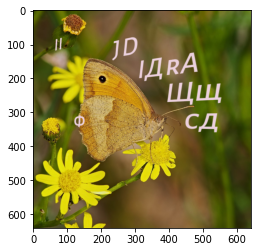

In [ ]:
text_generator = my_text_generator(alphabet, max_string_length)
print('The first generated text is:', next(text_generator))

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    get_image_generator(
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(60, 120),
        margin=60,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

#Bluring

In [ ]:
def image_generator_with_blur(image_generator, min_ksize, max_ksize, some_without_blur = True):
    while True:
        if (min_ksize % 2 == 0):
            min_ksize += 1
        possible_ksize = [i for i in range(min_ksize, max_ksize + 1, 2)]
        low_index = 0
        if some_without_blur:
            low_index = -1
        index = np.random.randint(low = low_index, high = len(possible_ksize))
        image, lines = next(image_generator)
        if index > -1:
            image = cv2.GaussianBlur(image, (possible_ksize[index], possible_ksize[index]), 0)
        yield (image, lines)

In [ ]:
min_ksize = 15
max_ksize = 43
blur_image_generators = [image_generator_with_blur(image_generators[i], min_ksize, max_ksize) for i in range(3)]
image_generators = blur_image_generators

#Loading weights and compiling

In [ ]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [ ]:
recognizer = keras_ocr.recognition.Recognizer(
   alphabet=alphabet
)
recognizer.model.load_weights(data_dir + '/32BatchSizeBlur300EpochsBest.h5')

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [ ]:
recognizer.compile()

#Recognition image generator

This image contains: J


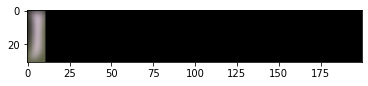

In [ ]:
max_length = 20
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

#Obtaining metrics

##Recoginition

In [ ]:
def recognizer_cer_from_generator(recognizer, generator, num_iter, case_sensitive = True):
    """Obtain avarage CER(Character Error Rate)

    Args:
        recognizer: recognizer model
        generator: generator of cropped images, ex. convert_image_generator_to_recognizer_input
        num_iter: number of iterations - aka number of samples
    """
    cer_arr = np.empty([num_iter], dtype=np.float128)
    for i in range(num_iter):
        image, ground_truth_text = next(generator)
        predicted_text = recognizer.recognize(image)
        if (not case_sensitive):
          predicted_text = predicted_text.lower()
          ground_truth_text = ground_truth_text.lower()
        cer_arr[i] = jiwer.cer(ground_truth_text, predicted_text)
    return np.mean(cer_arr)

In [ ]:
test_cer = recognizer_cer_from_generator(recognizer, recognition_image_generators[2], 600)
print(f'Test CER: {test_cer:.2f}')

Test CER: 0.23


In [ ]:
test_cer = recognizer_cer_from_generator(recognizer, recognition_image_generators[2], 600, False)
print(f'Non case sensitive Test CER: {test_cer:.2f}')

Non case sensitive Test CER: 0.17


##Full

In [ ]:
step_size = 5
num_iterations = 600
pipeline = keras_ocr.pipeline.Pipeline(detector = detector, recognizer = recognizer)
predicted_annotations = {}
ground_truth_annotations = {}

for step in tqdm.tqdm(range(0, num_iterations, step_size)):
    images = []
    for i in range(step_size):
        image, lines = next(image_generators[2])
        predicted_annotations[str(step + i)] = []
        for line in lines:
            text_line = ''.join([line_item[1] for line_item in line])
            last_index = len(line) - 1
            bounding_box = np.array([line[0][0][0], line[last_index][0][1], line[last_index][0][2], line[0][0][3]])
            predicted_annotations[str(step + i)].append(
             {
                 'text': text_line, 'vertices': bounding_box.tolist()
             } 
            )
        images.append(image)
    prediction_groups = pipeline.recognize(images)
    for i, predictions in enumerate(prediction_groups):
        ground_truth_annotations[str(step + i)] = [
            {
                'text': text, 'vertices': box.tolist()
            } for text, box in predictions
        ]

100%|██████████| 120/120 [06:08<00:00,  3.07s/it]


In [ ]:
results, (precision, recall) = keras_ocr.evaluation.score(ground_truth_annotations, predicted_annotations)

In [ ]:
print(f'Samples: {num_iterations}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Samples: 600
Precision: 0.51
Recall: 0.41
